In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

path = '../dataset/preprocessed data sets 0407/'
df_train_dynamic = pd.read_csv(path+'train data/train_dynamic_knn_impute_0407.csv')
df_train_static = pd.read_csv(path+'train data/train_static_0407.csv')
df_test_dynamic = pd.read_csv(path+'test data/test_dynamic_knn_impute_0407.csv')
df_test_static = pd.read_csv(path+'test data/test_static_0407.csv')
df_static = pd.read_csv('../dataset/assignment2_data_with_outcome/patient_static.csv')
df_static = df_static.loc[:,['stay_id','gender','admission_age', 'los_icu', 'hospital_expire_flag','charlson_score']]
print('Train set sizes:', df_train_dynamic.shape, df_train_static.shape)
print('Testn set sizes:', df_test_dynamic.shape, df_test_static.shape)
print('Static set sizes:', df_static.shape)

Train set sizes: (4220, 23) (1212, 22)
Testn set sizes: (1791, 23) (515, 22)
Static set sizes: (3573, 6)


c:\Users\admin\.conda\envs\py37-torch111\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_static['gender'] = df_static['gender'].apply(lambda x: 0 if x == 'M' else 1)
df_static['admission_age'] = df_static['admission_age'].apply(
    lambda x: int(x/10))
df_static['los_icu'] = df_static['los_icu'].apply(lambda x: int(x))

In [3]:
id_gt_vent_start_hour= df_train_static[df_train_static['stay_id'] == 30400145]['vent_start_hour'].values[0]
id_future_ehr_preidt_time= int(id_gt_vent_start_hour)-12
print('id_gt_vent_start_hour is',id_gt_vent_start_hour)
print('id_future_ehr_preidt_time is',id_future_ehr_preidt_time)

id_gt_vent_start_hour is 26.9
id_future_ehr_preidt_time is 14


In [4]:
columns = df_train_dynamic.columns
feature_column_list = columns[9:]
feature_column_list

Index(['calcium', 'creatinine', 'glucose', 'sodium', 'chloride', 'hemoglobin',
       'wbc', 'alt', 'ast', 'alp', 'bilirubin_total', 'bilirubin_direct',
       'bilirubin_indirect', 'pt'],
      dtype='object')

In [5]:
def normalise_dyn(df_dyn):
    dynamic_cols = df_train_dynamic.iloc[:, 4:]
    dynamic_mean = dynamic_cols.mean()
    dynamic_std = dynamic_cols.std()
    df_dyn.iloc[:, 4:] = (dynamic_cols - dynamic_mean) / dynamic_std
    df_dyn = df_dyn.drop(
        ['charttime_hour_2', 'charttime_hour_1',
         'charttime_hour_6', 'charttime_hour_12', 'charttime_hour_24'], axis=1)
    return df_dyn


df_train_dynamic_norm = normalise_dyn(df_train_dynamic)
df_test_dynamic_norm = normalise_dyn(df_test_dynamic)
columns = df_train_dynamic_norm.columns
feature_column_list = columns[4:]

train_X_dict = {}
train_X_dict_num = {}
test_X_dict = {}
test_X_dict_num = {}


for is_train, df in [(True, df_train_dynamic_norm), (False, df_test_dynamic_norm)]:
    dict_to_use = train_X_dict if is_train else test_X_dict
    dict_num_to_use = train_X_dict_num if is_train else test_X_dict_num
    for stay_id in df['stay_id'].unique():
        df_sample = df.loc[(df['stay_id'] == stay_id) & (
            df['charttime_hour'] >= -78), columns]
        dict_to_use[stay_id] = df_sample.reset_index(drop=True)
        dict_num_to_use[stay_id] = df_sample.shape[0]


def get_nan_60h_df(columns):
    df = pd.DataFrame(columns=columns)
    for i in range(90):
        df.loc[i] = np.nan
        df.loc[i, 'charttime_hour'] = -78 + 1 * i
    return df

def process_dynamic_df(df):
    nan_60h_df = get_nan_60h_df(columns)
    result_dict = {}
    for stay_id in df['stay_id'].unique():
        new_60h_df = nan_60h_df.copy()
        df_sample = df.loc[(df['stay_id'] == stay_id) & (
            df['charttime_hour'] >= -78), columns]
        df_sample['charttime_hour'] = df_sample['charttime_hour'] // 1 * 1
        for i in range(df_sample.shape[0]):
            tmp = df_sample.iloc[i]['charttime_hour']
            new_60h_df[new_60h_df['charttime_hour'] == tmp] = df_sample.iloc[i]
            tmp_df = new_60h_df.iloc[:, 3:].copy()
            result_dict[stay_id] = tmp_df
    return result_dict

train_X_dict_time_series = process_dynamic_df(df_train_dynamic_norm)
max_10 = sorted(train_X_dict_num.items(),
                key=lambda x: x[1], reverse=True)[:10]
print(max_10)

[(30400145, 14), (31986541, 12), (38134128, 12), (39657181, 11), (37022112, 10), (30739724, 9), (31146615, 9), (36981368, 9), (38961723, 9), (31033547, 8)]


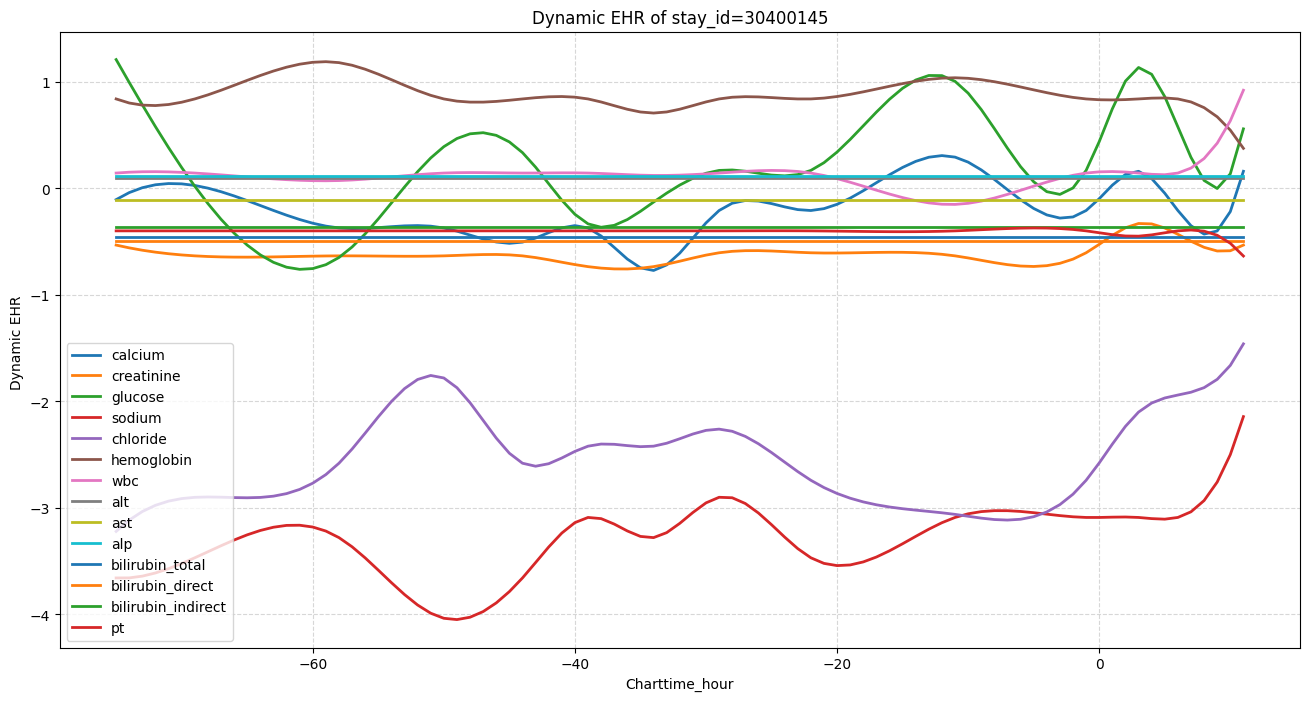

In [6]:
stay_id = 30400145
df = train_X_dict_time_series[stay_id]
df = df.fillna(value=np.nan)
df.interpolate(method='cubic',  limit_direction='both', inplace=True, axis=0)
df.plot(x='charttime_hour', y=feature_column_list,
        linewidth=2,  figsize=(16, 8))

plt.grid(linestyle='--', alpha=0.5)
plt.title('Dynamic EHR of stay_id=30400145')
plt.xlabel('Charttime_hour')
plt.ylabel('Dynamic EHR ')
plt.savefig('mei-dyn-ehr-v1.png', transparent=True)

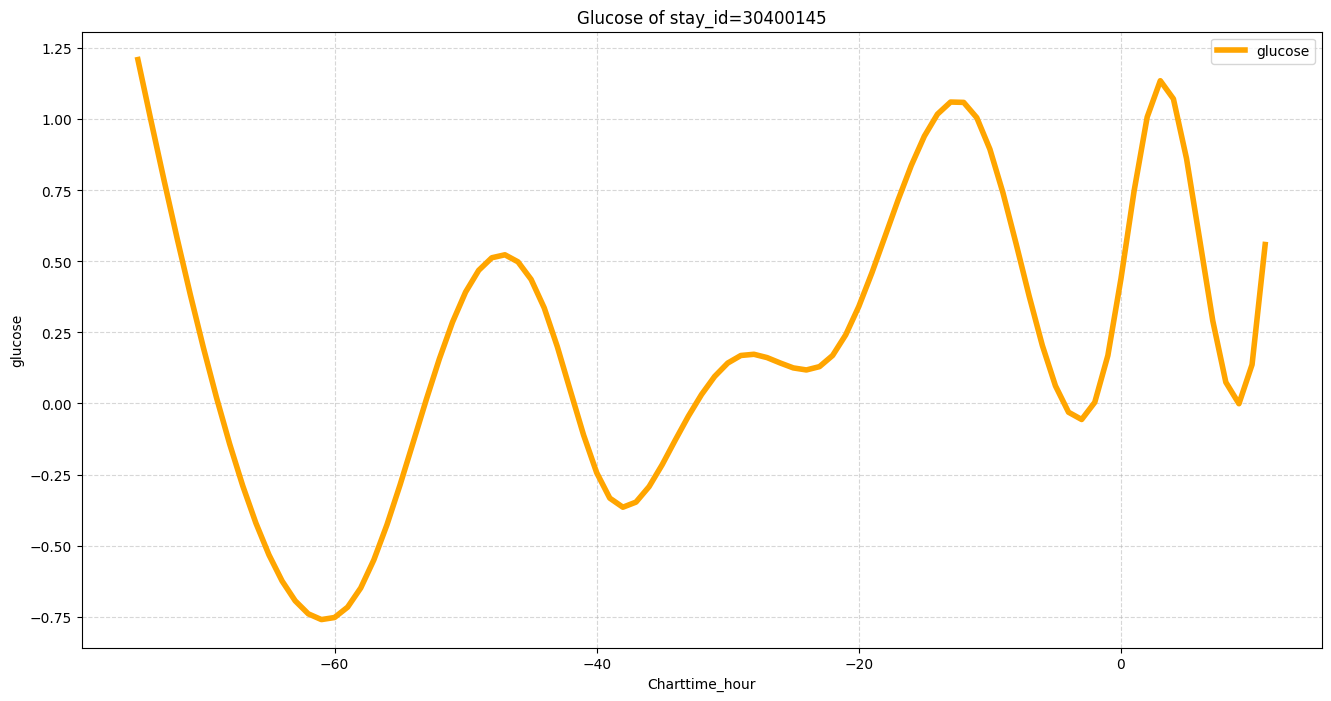

In [7]:
df.plot(x='charttime_hour', y='glucose',
        label='glucose', linewidth=4, color='orange', figsize=(16, 8))
plt.grid(linestyle='--', alpha=0.5)
plt.title('Glucose of stay_id=30400145')
plt.xlabel('Charttime_hour')
plt.ylabel('glucose')

plt.savefig('mei-glucose-v1.png',transparent = True)

In [8]:
import time
import math
import numpy as np
import random
import pandas as pd

import torch
import torch.nn as nn
from torch.autograd import Variable

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

In [9]:
df_stock = df.iloc[:, 3:4]
cols = df_stock.columns.tolist()
cols_num= len(cols)
df_stock.interpolate(
    method='linear',  limit_direction='both', inplace=True, axis=0)
scaler = MinMaxScaler(feature_range=(-1, 1))
for i in cols:
    df_stock[i] = scaler.fit_transform(df_stock[i].values.reshape(-1, 1))

def load_data(stock, look_back, future_time):
    data_raw = stock.values 
    length = len(data_raw)

    data_raw = np.concatenate((data_raw, np.zeros((future_time, cols_num))), axis=0)
    print('afdasfasdf', data_raw .shape)
    data = []
    future = []
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])
    data = np.array(data)
    test_set_size = int(np.round(0.2*(data.shape[0]-future_time)))
    train_set_size = (data.shape[0]-future_time) - (test_set_size)
    future_set_size = future_time
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    x_test = data[train_set_size:length-look_back, :-1]
    y_test = data[train_set_size:length-look_back, -1, :]
    x_future = data[length-look_back:, :-1]
    return [x_train, y_train, x_test, y_test, x_future]

look_back = 24
x_train, y_train, x_test, y_test, x_future = load_data(
    df_stock, look_back, id_future_ehr_preidt_time)

x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train = torch.from_numpy(y_train).type(torch.Tensor)
y_test = torch.from_numpy(y_test).type(torch.Tensor)
x_future = torch.from_numpy(x_future).type(torch.Tensor)

# Build model
#####################
input_dim = cols_num
hidden_dim = 32
num_layers = 4
output_dim = cols_num

afdasfasdf (104, 1)


c:\Users\admin\.conda\envs\py37-torch111\lib\site-packages\pandas\core\frame.py:10720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  **kwargs,
c:\Users\admin\.conda\envs\py37-torch111\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:

# Here we define our model as a class
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        # Hidden dimensions
        self.hidden_dim = hidden_dim
        # Number of hidden layers
        self.num_layers = num_layers
        # batch_first=True causes input/output tensors to be of shape
        # (batch_dim, seq_dim, feature_dim)
        self.lstm = nn.LSTM(input_dim, hidden_dim,
                            num_layers, batch_first=True)
        # Readout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(
            0), self.hidden_dim).requires_grad_()
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(
            0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim,
             output_dim=output_dim, num_layers=num_layers)

loss_fn = torch.nn.MSELoss()

optimiser = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)
print(len(list(model.parameters())))
for i in range(len(list(model.parameters()))):
    print(list(model.parameters())[i].size())


LSTM(
  (lstm): LSTM(1, 32, num_layers=4, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)
18
torch.Size([128, 1])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([128, 32])
torch.Size([128, 32])
torch.Size([128])
torch.Size([128])
torch.Size([1, 32])
torch.Size([1])


In [11]:
# Train model
#####################
num_epochs = 600
hist = np.zeros(num_epochs)
seq_dim = look_back-1

for t in range(num_epochs):
    y_train_pred = model(x_train)
    loss = loss_fn(y_train_pred, y_train)
    if t % 50 == 0 and t != 0:
        print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

Epoch  50 MSE:  0.11739707738161087
Epoch  100 MSE:  0.0022664805874228477
Epoch  150 MSE:  0.0008756498573347926
Epoch  200 MSE:  0.0005368082784116268
Epoch  250 MSE:  0.0002668621891643852
Epoch  300 MSE:  7.451795681845397e-05
Epoch  350 MSE:  0.0005866325227543712
Epoch  400 MSE:  1.6672305719112046e-05
Epoch  450 MSE:  1.0788938197947573e-05
Epoch  500 MSE:  8.91374747880036e-06
Epoch  550 MSE:  7.652033673366532e-06


In [12]:
y_test_pred = model(x_test)
y_train_pred = model(x_train)
y_future_pred = model(x_future)
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test.detach().numpy())
y_future_pred = scaler.inverse_transform(y_future_pred.detach().numpy())

In [13]:
trainScore = math.sqrt(mean_squared_error(y_train[:, 0], y_train_pred[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:, 0], y_test_pred[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 0.01 RMSE
Test Score: 0.38 RMSE


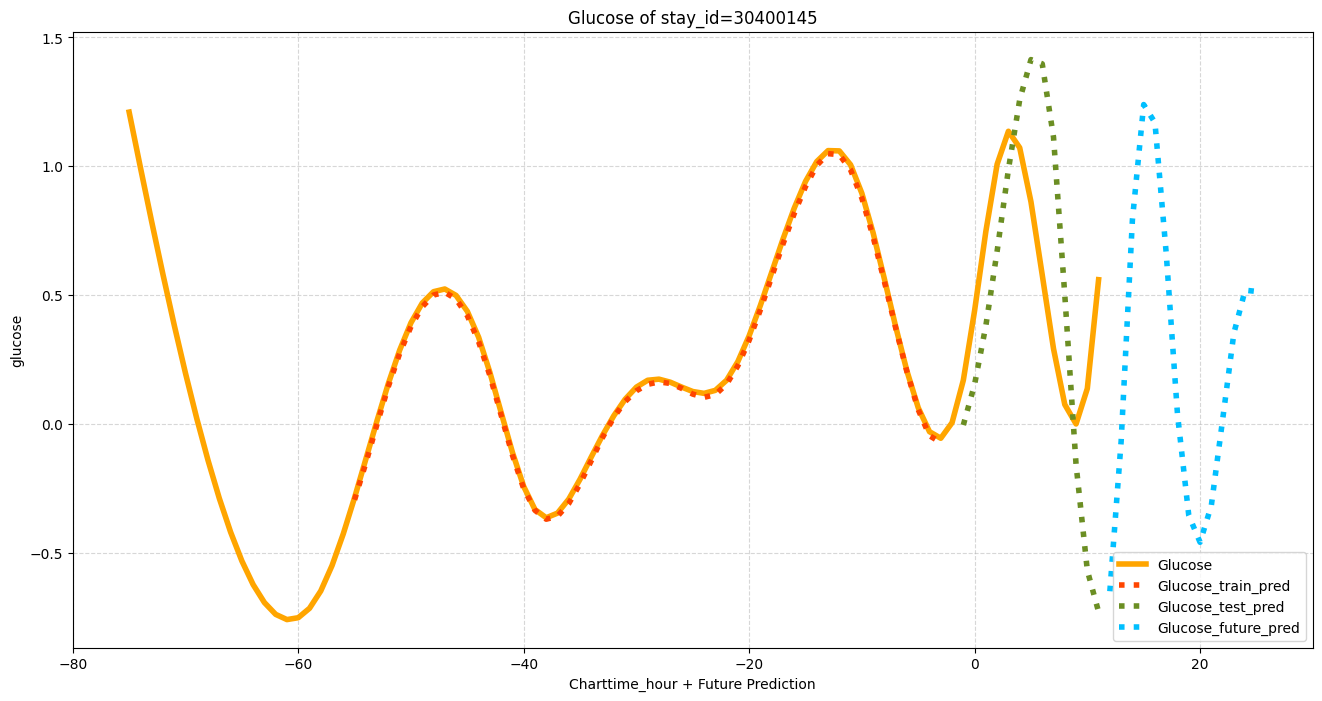

In [14]:
df.plot(x='charttime_hour', y='glucose',
        label='Glucose', linewidth=4, color='orange', figsize=(16, 8))

plt.plot(df_stock[len(df_stock)-len(y_train):].index-78-id_future_ehr_preidt_time, y_train_pred, label='Glucose_train_pred' ,linewidth=4,  color='orangered', linestyle=":")
plt.plot(df_stock[len(df_stock)-len(y_test):].index-78, y_test_pred, label='Glucose_test_pred' ,linewidth=4,  color='olivedrab', linestyle=":")
plt.plot(df_stock[len(df_stock)-id_future_ehr_preidt_time:].index+id_future_ehr_preidt_time-78,
         y_future_pred, linewidth=4,  color='deepskyblue',  linestyle=":", label='Glucose_future_pred',)

plt.grid(linestyle='--', alpha=0.5)
plt.title('Glucose of stay_id=30400145')
plt.xlabel('Charttime_hour + Future Prediction')
plt.ylabel('glucose')
plt.legend()
plt.show()
# plt.savefig('mei-future-v2.png',transparent = True) 